# Preprocess AMSR sea ice concentration
Remote sensing sea ice concentration can be downloaded from Bremen University [here](https://seaice.uni-bremen.de/databrowser/#p=sic). The data is stored in netCDF-files, one for each day. In this notebook we select the desired region and combine those to a single data set. The daily netCDF files need to be downloaded before running this notebook.

In addition, we also need a grid file to convert from polar stereographic coordinates to longitude/latitude. The data-folder in this repository contains a grid file for the Antarctic 6.25 km resolution grid. Grid files can also be downloaded from [meereisportal](https://data.meereisportal.de/data/iup/hdf/grid).

In [1]:
import xarray as xr
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs

import misc

In [2]:
def plot_sic(sic, extent = None, projection = ccrs.SouthPolarStereo(), **kwargs):
    """
    Plots AMSR sea ice concentration map
    
    Parameters:
        sic    : xarray.Dataset (no time dimesion) created by preprocess_sea_ice_concentration.ipynb
        extent : Optional extent of map, given in [lon_min, lon_max, lat_min, lat_max] 
        
        **kwargs is passed to plt.pcolormesh
    """    
    ax = plt.axes(projection=projection)

    # Plot sea ice concentration
    cs = ax.pcolormesh(sic.Longitudes, sic.Latitudes, sic.z,
                       transform = ccrs.PlateCarree(), # data projection
                       cmap = cmo.ice,
                      )
    
    if extent is not None:
        ax.set_extent(extent)
    
    # Adjust grid lines
    gl = ax.gridlines(draw_labels = True, 
                      y_inline = False, # force y-axis ticks to be outside the plot
                     )
    gl.bottom_labels = True
    gl.top_labels    = False
    gl.left_labels   = True                  
    gl.right_labels  = False

    # colorbar
    plt.colorbar(cs, label = 'sea ice concentration (%)')
    
    plt.show()
    
    return

## Load data files
The files are assumed to be named in the following way:
> <dataname\>\<yyyymmdd\>\<version\>\<extension\>

Example:
> path/to/datafolder/asi-AMSR2-s6250-20191111-v5.4.nc

In [3]:
datafolder = 'path/to/AMSR2/data/' # Update with real folder
dataname   = 'asi-AMSR2-s6250-'
version    = '-v5.4'
extension  = '.nc'

gridfile   = '../data/LongitudeLatitudeGrid-s6250-Antarctic.nc'

# Get full filename of data files:
full_name = os.path.join(datafolder,dataname + '*' + version + extension)
datafiles = sorted(glob.glob(full_name))

Combine all files to a single data set. This will add a time dimension to the dataset, where the date is extracted from the file names. We will also add a timestamp 12:00 to the files.

In [4]:
dateformat = '%Y%m%d'
date_start = len(dataname)
date_end   = date_start + 8

time = []    
for file in datafiles:
    date = os.path.basename(file)[date_start:date_end]
    datetime = pd.to_datetime(date + '12:00', format = dateformat+'%H:%M')
    time.append(datetime)
    
sic = xr.open_mfdataset(datafiles, 
                        concat_dim = 'time', 
                        combine = 'nested',
                       ).assign_coords({"time" : (time)})
sic

<xarray.Dataset>
Dimensions:              (time: 22, x: 1264, y: 1328)
Coordinates:
  * x                    (x) float64 -3.947e+06 -3.941e+06 ... 3.947e+06
  * y                    (y) float64 -3.947e+06 -3.941e+06 ... 4.347e+06
  * time                 (time) datetime64[ns] 2019-07-26T12:00:00 ... 2019-1...
Data variables:
    polar_stereographic  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    z                    (time, y, x) float32 dask.array<chunksize=(1, 1328, 1264), meta=np.ndarray>
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sat Jul 27 05:25:42 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

Now we add the longitude and latitude grids to the data set

In [5]:
grid = xr.open_dataset(gridfile)
sic  = xr.combine_by_coords([sic,grid])
sic

<xarray.Dataset>
Dimensions:              (y: 1328, x: 1264, time: 22)
Coordinates:
  * x                    (x) float64 -3.947e+06 -3.941e+06 ... 3.947e+06
  * y                    (y) float64 -3.947e+06 -3.941e+06 ... 4.347e+06
  * time                 (time) datetime64[ns] 2019-07-26T12:00:00 ... 2019-1...
Data variables:
    Longitudes           (y, x) float32 ...
    Latitudes            (y, x) float32 ...
    polar_stereographic  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    z                    (time, y, x) float32 dask.array<chunksize=(1, 1328, 1264), meta=np.ndarray>
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sat Jul 27 05:25:42 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

As a sanity check, we plot the sea ice concentration of the first day in the data set

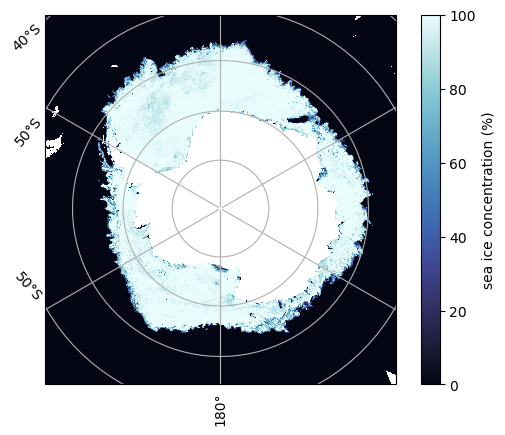

In [6]:
plot_sic(sic.isel(time=0))

## Select region and time interval

In [7]:
# select area
lon_min = -10;
lon_max = 10;
lat_min = -60;
lat_max = -54;

xy_ilims   = misc.get_xy_limits_of_region(sic, lon_min, lon_max, lat_min, lat_max)
sic_region = sic.isel(x = slice(xy_ilims[0],xy_ilims[1]+1), y = slice(xy_ilims[2],xy_ilims[3]+1))

# separate winter and spring data
time_separator = pd.to_datetime('20190901', format = dateformat)

sic_spring = sic_region.sel(time = sic_region.time > time_separator)
sic_winter = sic_region.sel(time = sic_region.time < time_separator)

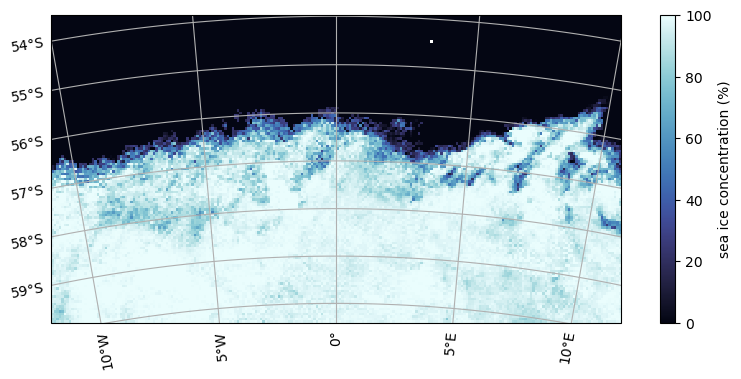

In [8]:
plt.figure(figsize=(10,4))
plot_sic(sic_spring.isel(time=0))

## Save data sets

In [9]:
savefolder = '../data/'

sic_spring.load().to_netcdf(os.path.join(savefolder, 'sic_spring.nc'))
sic_winter.load().to_netcdf(os.path.join(savefolder, 'sic_winter.nc'))